In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:

df = pd.read_csv("customer_behavior_analytcis.csv")
df.head()


,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004


In [3]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
 5   customer_id       999 non-null    object 
dtypes: float64(5), object(1)
memory usage: 47.0+ KB
None
       total_purchases  avg_cart_value  total_time_spent  product_click  \
count       979.000000      979.000000        999.000000     979.000000   
mean         11.570991       75.457978         49.348759      28.237998   
std           7.016327       55.067835         32.730973      16.296384   
min           0.000000       10.260000          5.120000       4.000000   
25%           6.000000       33.130000         22.375000      16.000000   
50%         

In [4]:
numeric_cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']

knn_imputer = KNNImputer(n_neighbors=5)

df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])
print("Missing values after KNN imputation:")
print(df[['total_purchases', 'avg_cart_value', 'product_click']].isnull().sum())


Missing values after KNN imputation:
total_purchases    0
avg_cart_value     0
product_click      0
dtype: int64


In [5]:
numeric_cols = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

In [6]:

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

cluster_labels = kmeans.fit_predict(X_scaled)

df['cluster'] = cluster_labels


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [7]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, cluster_labels)
print("Silhouette Score:", score)


Silhouette Score: 0.6279358530369642


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [12]:

cluster_summary = df.groupby('cluster')[['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']].mean()
print(cluster_summary)


         total_purchases  avg_cart_value  total_time_spent  product_click  \
cluster                                                                     
0              10.177177      147.229405         40.389730      19.903303   
1              19.684685       30.458432         17.511682      14.945345   
2               4.860661       49.064583         90.144865      49.737538   

         discount_counts  
cluster                   
0               1.945946  
1               9.969970  
2               1.024024  


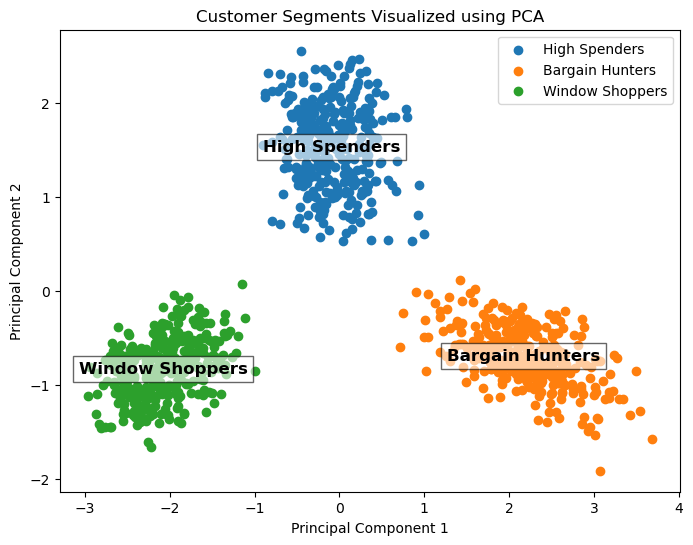

In [19]:
import matplotlib.pyplot as plt

cluster_mapping = {
    0: 'High Spenders',
    1: 'Bargain Hunters',
    2: 'Window Shoppers'
}

plt.figure(figsize=(8,6))
for cluster in sorted(cluster_mapping.keys()):
    segment_label = cluster_mapping[cluster]
    cluster_points = X_pca[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=segment_label)
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], segment_label, fontsize=12, 
             weight='bold', horizontalalignment='center', verticalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segments Visualized using PCA')
plt.legend()
plt.show()


In [21]:
print("Cluster to Customer Segment Mapping:")
for cluster, segment in cluster_mapping.items():
    print(f"Cluster {cluster}: {segment}")


Cluster to Customer Segment Mapping:
Cluster 0: High Spenders
Cluster 1: Bargain Hunters
Cluster 2: Window Shoppers


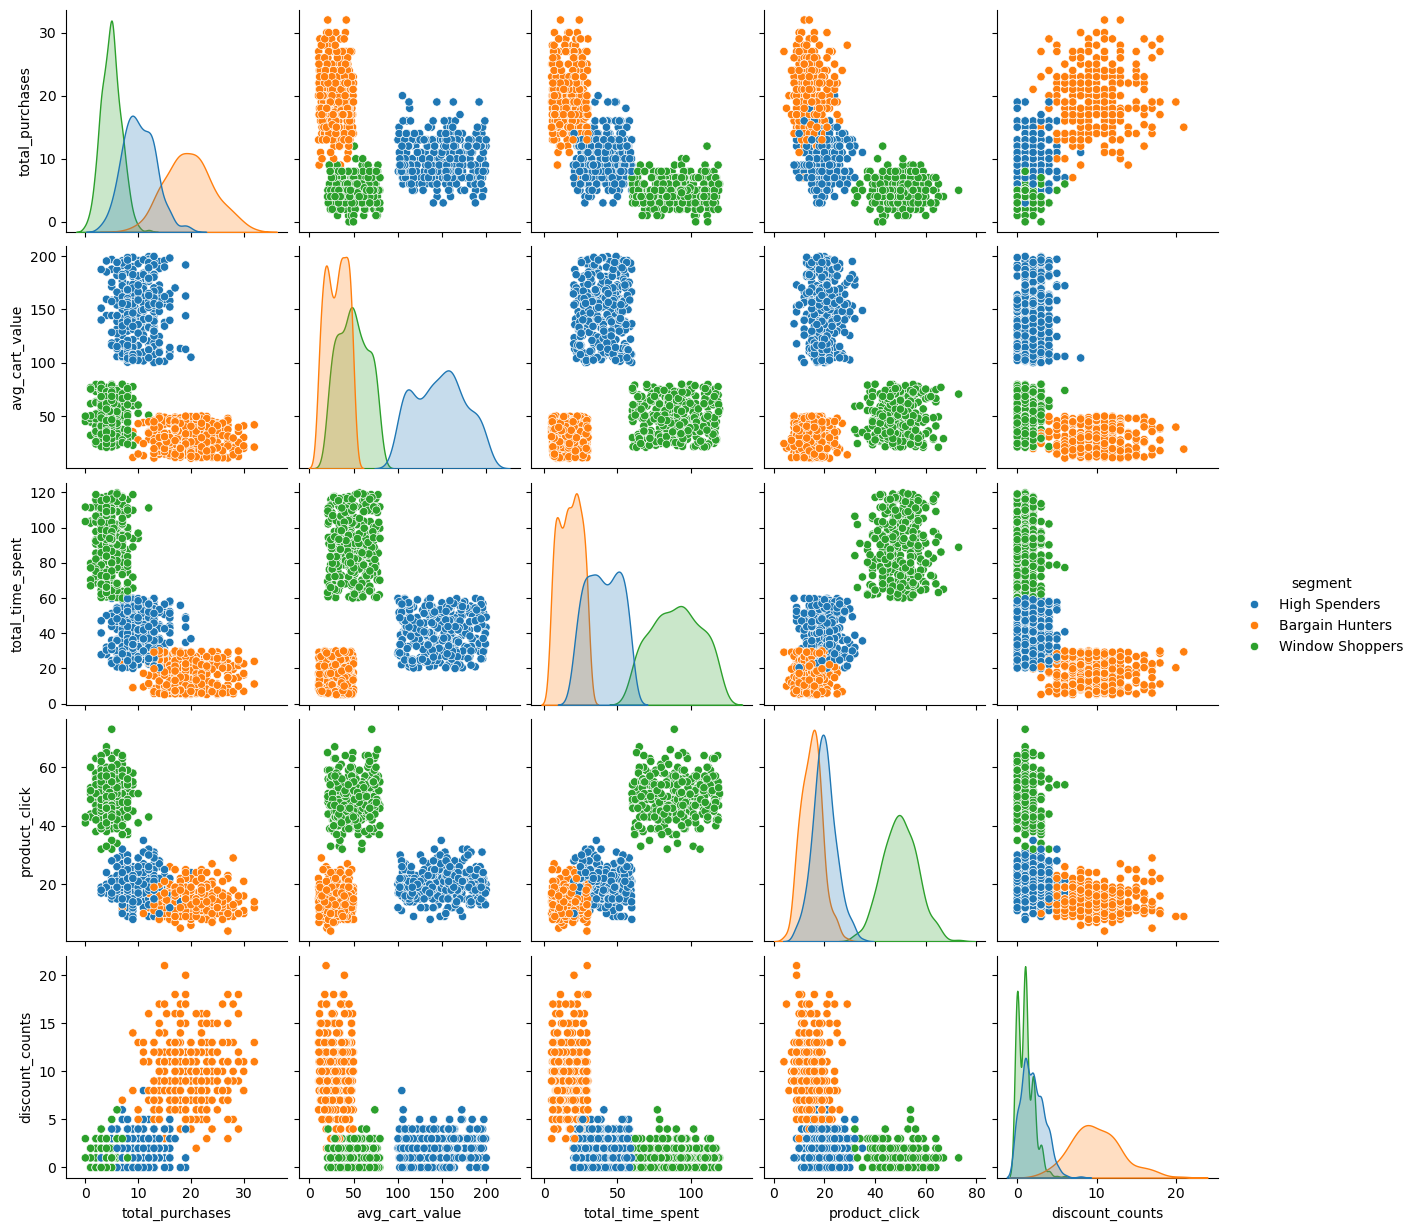

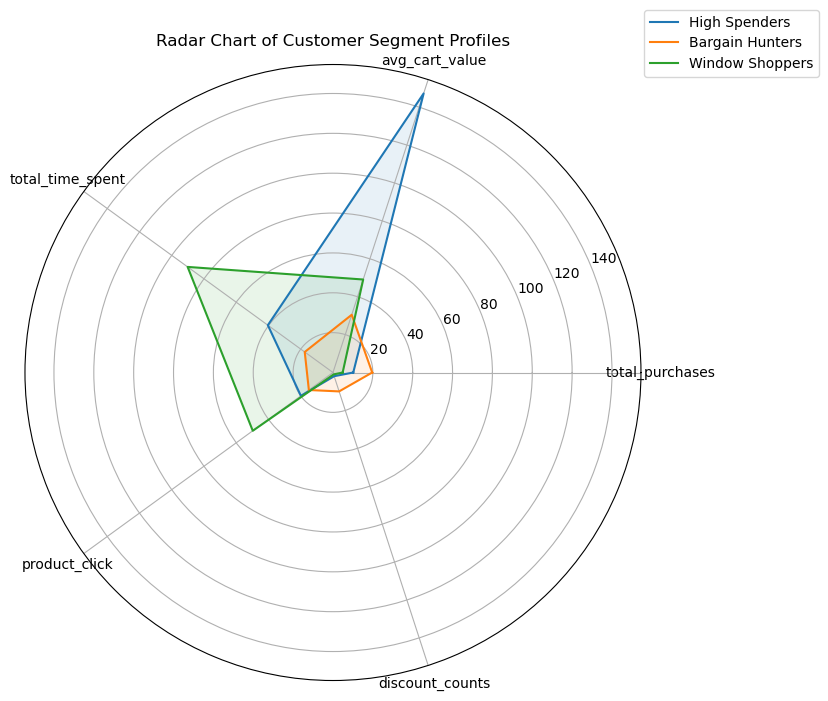

In [23]:
cluster_mapping = {
    0: 'High Spenders',
    1: 'Bargain Hunters',
    2: 'Window Shoppers'
}
import seaborn as sns
df['segment'] = df['cluster'].map(cluster_mapping)

sns.pairplot(df, 
             vars=['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts'], 
             hue='segment', 
             diag_kind='kde') 
import matplotlib.pyplot as plt
import numpy as np

categories = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # complete the circle

plt.figure(figsize=(8,8))

for cluster in sorted(cluster_mapping.keys()):
    values = cluster_summary.loc[cluster, categories].values.tolist()
    values += values[:1]  # close the loop
    plt.polar(angles, values, label=cluster_mapping[cluster])
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title("Radar Chart of Customer Segment Profiles")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


In [25]:
cluster_mapping = {
    0: 'High Spenders',
    1: 'Bargain Hunters',
    2: 'Window Shoppers'
}


In [27]:

df['segment'] = df['cluster'].map(cluster_mapping)


In [29]:

print(df[['customer_id', 'total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts', 'segment']].head(10))


  customer_id  total_purchases  avg_cart_value  total_time_spent  \
0     CM00000              7.0          129.34             52.17   
1     CM00001             22.0           24.18              9.19   
2     CM00002              2.0           32.18             90.69   
3     CM00003             25.0           26.85             11.22   
4     CM00004              7.0          125.45             34.19   
5     CM00005             12.0          199.56             43.39   
6     CM00006             23.0           43.48             13.11   
7     CM00007             27.0           46.58              7.20   
8     CM00008              9.0           35.10              9.24   
9     CM00009             30.0           40.69             16.34   

   product_click  discount_counts          segment  
0           18.0              0.0    High Spenders  
1           15.0              7.0  Bargain Hunters  
2           50.0              2.0  Window Shoppers  
3           16.0             10.0  Barg

In [31]:
print(df['segment'].value_counts())


segment
High Spenders      333
Bargain Hunters    333
Window Shoppers    333
Name: count, dtype: int64


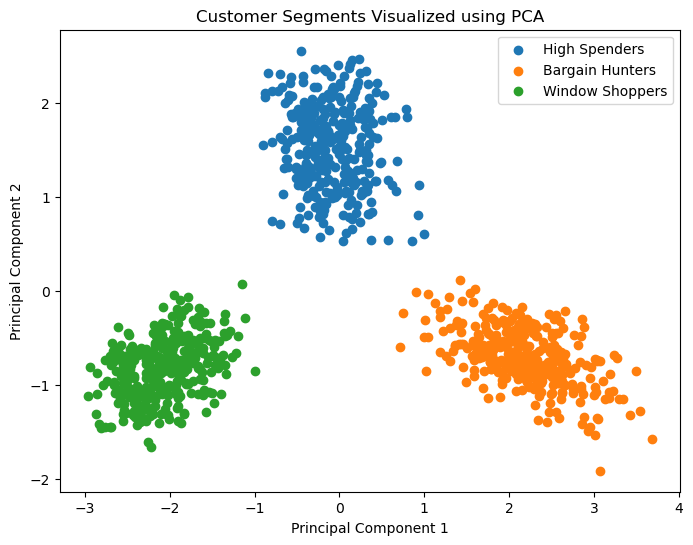

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for cluster in sorted(cluster_mapping.keys()):
    segment_label = cluster_mapping[cluster]
    # Plot points belonging to this cluster
    plt.scatter(X_pca[cluster_labels == cluster, 0],
                X_pca[cluster_labels == cluster, 1],
                label=segment_label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segments Visualized using PCA')
plt.legend()
plt.show()


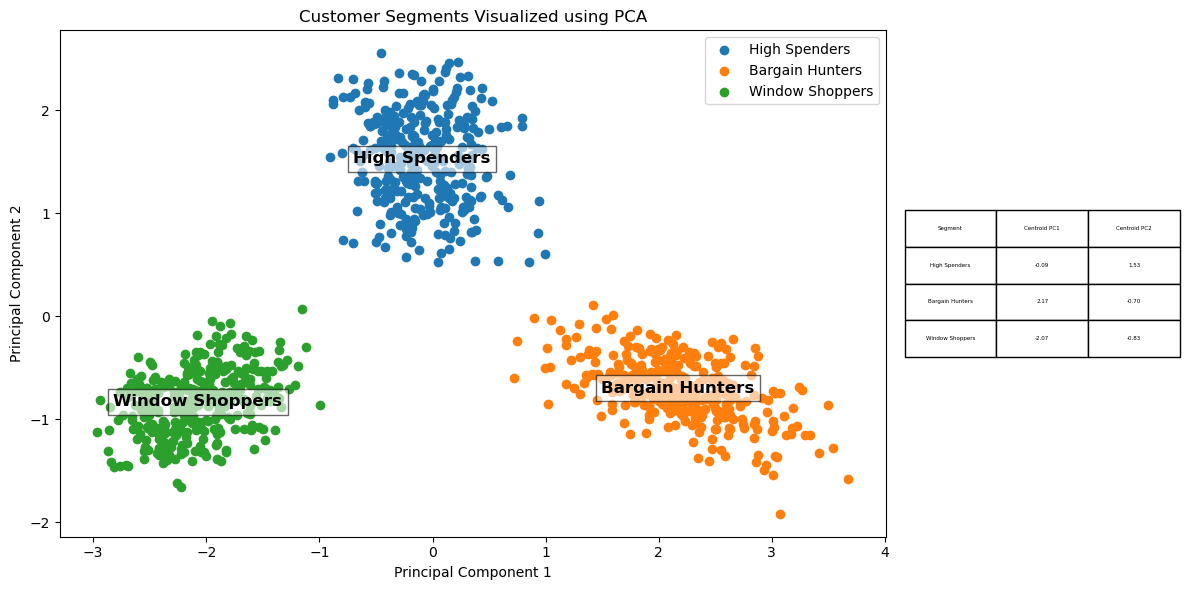

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Suppose you already have the following:
# 1. X_pca: PCA-transformed array of shape (n_samples, 2)
# 2. cluster_labels: array of cluster assignments (0, 1, 2) for each sample
# 3. cluster_mapping: dictionary mapping cluster number -> segment name
#    e.g. {0: 'High Spenders', 1: 'Bargain Hunters', 2: 'Window Shoppers'}

# Create a figure with 2 subplots: one for the scatter plot, one for the table
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax_scatter = fig.add_subplot(gs[0])
ax_table = fig.add_subplot(gs[1])

# --- 1) Scatter Plot with Cluster Labels ---
for cluster in sorted(cluster_mapping.keys()):
    segment_label = cluster_mapping[cluster]
    
    # Extract points for this cluster
    cluster_points = X_pca[cluster_labels == cluster]
    
    # Scatter them, labeling by segment name
    ax_scatter.scatter(cluster_points[:, 0], 
                       cluster_points[:, 1], 
                       label=segment_label)
    
    # Calculate centroid in PCA space
    centroid = cluster_points.mean(axis=0)
    
    # Annotate centroid
    ax_scatter.text(centroid[0], centroid[1],
                    segment_label,
                    fontsize=12,
                    weight='bold',
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

ax_scatter.set_xlabel('Principal Component 1')
ax_scatter.set_ylabel('Principal Component 2')
ax_scatter.set_title('Customer Segments Visualized using PCA')
ax_scatter.legend()

# --- 2) Table Showing Centroids on the Right ---
ax_table.axis('off')  # Hide the default axes

# Prepare the table data
# Header row plus one row per cluster
table_data = [['Segment', 'Centroid PC1', 'Centroid PC2']]
for cluster in sorted(cluster_mapping.keys()):
    segment_label = cluster_mapping[cluster]
    centroid = X_pca[cluster_labels == cluster].mean(axis=0)
    table_data.append([segment_label, 
                       f"{centroid[0]:.2f}", 
                       f"{centroid[1]:.2f}"])

# Create the table
table = ax_table.table(cellText=table_data,
                       cellLoc='center',
                       loc='center')
table.scale(1, 2)  # Make the table bigger for readability

plt.tight_layout()
plt.show()


In [271]:
import numpy as np
from sklearn.decomposition import PCA

# Suppose X_scaled is your scaled data, and these are your original feature names:
features = ['total_purchases','avg_cart_value','total_time_spent','product_click','discount_counts']

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Print explained variance ratio
print("Explained Variance Ratio for PC1 and PC2:", pca.explained_variance_ratio_)

# Examine the loadings (components)
loadings = pca.components_

# Each row of `loadings` corresponds to a principal component,
# and each column corresponds to one feature in `features`.
for i, pc in enumerate(loadings):
    print(f"\n=== Principal Component {i+1} ===")
    for feature, loading_value in zip(features, pc):
        print(f"{feature:20s}: {loading_value:.4f}")



Explained Variance Ratio for PC1 and PC2: [0.63746878 0.26116475]

=== Principal Component 1 ===
total_purchases     : 0.5114
avg_cart_value      : -0.0984
total_time_spent    : -0.5114
product_click       : -0.4866
discount_counts     : 0.4802

=== Principal Component 2 ===
total_purchases     : -0.1030
avg_cart_value      : 0.8411
total_time_spent    : -0.2229
product_click       : -0.3600
discount_counts     : -0.3203


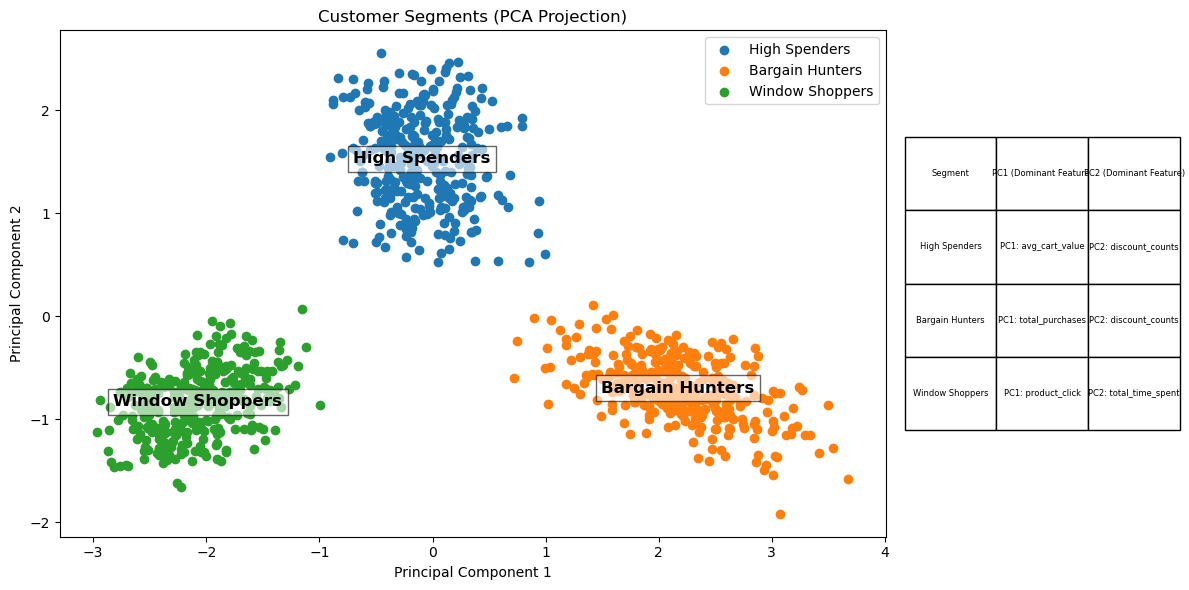

In [291]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Assume these variables already exist:
# X_pca: the PCA-transformed data (2D array of shape (n_samples, 2))
# cluster_labels: the cluster assignments from K-Means for each customer
# cluster_mapping: dictionary mapping cluster number to segment name, e.g.,
#    {0: 'High Spenders', 1: 'Bargain Hunters', 2: 'Window Shoppers'}

# For this example, we'll use the following assumed mapping (from our previous discussion):
cluster_mapping = {
    0: 'High Spenders',
    1: 'Bargain Hunters',
    2: 'Window Shoppers'
}

# And we define a manual interpretation for each segment as discussed:
segment_details = [
    ["High Spenders", "PC1: avg_cart_value", "PC2: discount_counts"],
    ["Bargain Hunters", "PC1: total_purchases", "PC2: discount_counts"],
    ["Window Shoppers", "PC1: product_click", "PC2: total_time_spent"]
]

# Create a figure with two columns: one for the scatter plot, one for the table.
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax_scatter = fig.add_subplot(gs[0])
ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')  # Turn off the axis for the table

# Plot the PCA scatter plot with cluster labels.
for cluster in sorted(cluster_mapping.keys()):
    segment_label = cluster_mapping[cluster]
    # Extract points belonging to the current cluster
    cluster_points = X_pca[cluster_labels == cluster]
    ax_scatter.scatter(cluster_points[:, 0],
                       cluster_points[:, 1],
                       label=segment_label)
    
    # Calculate and annotate the cluster centroid.
    centroid = cluster_points.mean(axis=0)
    ax_scatter.text(centroid[0], centroid[1],
                    segment_label,
                    fontsize=12,
                    weight='bold',
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

ax_scatter.set_xlabel('Principal Component 1')
ax_scatter.set_ylabel('Principal Component 2')
ax_scatter.set_title('Customer Segments (PCA Projection)')
ax_scatter.legend()

# Build the table data.
table_data = [["Segment", "PC1 (Dominant Feature)", "PC2 (Dominant Feature)"]]
for row in segment_details:
    table_data.append(row)

# Create the table on the right-hand side.
table = ax_table.table(cellText=table_data,
                       cellLoc='center',
                       loc='center')
table.scale(1, 2)  # Adjust the table size for better readability
table.auto_set_font_size(False)
table.set_fontsize(6)
# Create the table on the right-hand side.


table.scale(1, 2)  # Adjust the table size for better readability
plt.tight_layout()
plt.show()
